#### 07/27 <br>GEM 하이퍼파라미터 비교 실험 (cl7LwF.ipynb 복사본)

# Continual Learning 데이터 만들기

## 데이터셋 다운로드

우선 데이터셋 다운로드부터 먼저 시작한다. 데이터셋은 미리 업로드된 구글 드라이브 링크로부터 다운로드하게 된다. 업로드된 파일을 내려받기 전에 프로젝트 디렉터리에 `data` 폴더가 있는지 검사하고 그 폴더 안에 각 데이터의 `.zip` 파일이 미리 받아졌는지 먼저 확인하고 (md5 해싱 이용) 파일이 문제가 없으면 압축을 푼다.

In [36]:
import os
import gdown
import hashlib
import zipfile
from datetime import datetime

def generate_save_folder_name(model_name, strategy, patterns_per_exp=150, memory_strength=0.3, memory_size=200):
    # 현재의 날짜와 시간
    now = datetime.now()
    # 월과 일을 포맷으로 하는 문자열을 생성
    date_str = now.strftime("%m%d")
    if strategy == "gem":
        save_folder_name = model_name.upper() + "_" + strategy.upper() + "_ppe:" +  str(patterns_per_exp) + "_ms:" + str(memory_strength)+ "_"+ date_str
    elif strategy == "replay":
        save_folder_name = model_name.upper() + "_" + strategy.upper() + "_memory_size:" + str(memory_size)+ "_" + date_str
    else: 
        save_folder_name = model_name.upper() + "_" + strategy.upper() + "_"+ date_str

    return save_folder_name


def get_hash(filename):
    with open(filename, "rb") as f:
        data = f.read()
        hash = hashlib.md5(data).hexdigest()
    
    return hash

data_info = {
    "cwru": {"link": "https://drive.google.com/uc?id=1JfnCzisg0wTSkWw_I5sNLcvQMD5mloJy",
             "hash": "a66d9ea53e5b9959829c1d1057abc377"},
    "mfpt": {"link": "https://drive.google.com/uc?id=1HDmX9-v8dV1-53nvM9lSDj-2-S2_Dss5",
             "hash": "fcf44622538307e33503cb7f24fd33d3"},
    "ottawa": {"link": "https://drive.google.com/uc?id=1WelJO5RMFwKoNdumhtW-__PC881fh4J_",
               "hash": "ca0142f52e950b5579985586a6acc96a"
    }
}

os.chdir(os.path.join(globals()['_dh'][0], ".."))

if not os.path.isdir("./data"):
    os.mkdir("./data")

for key in data_info:
    filename = f"./data/{key}.zip"
    if not os.path.isfile(filename):
        gdown.download(data_info[key]["link"], f"./data/{key}.zip")
    else:
        hash = get_hash(filename)
        if hash != data_info[key]["hash"]:
            os.remove(filename)
            gdown.download(data_info[key]["link"], f"./data/{key}.zip")

for key in data_info:
    filename = f"./data/{key}.zip"
    zipfile.ZipFile(filename).extractall("./data/")


In [9]:
from dfb.download import *

dfs = {}

for key in data_info:
    dfs[key] = download_data(f"./data/{key}", key)

File is already existed, use existed file.


In [10]:
from dfb.databuilder import *

# level 1 데이터셋 제작

df_cwru = dfs["cwru"]
df_mfpt = dfs["mfpt"]
df_ottawa = dfs["ottawa"]

data_level1 = {}

df_load1 = df_cwru[(df_cwru["load"] == 1) & (df_cwru["label"] != 999)]
df_load2 = df_cwru[(df_cwru["load"] == 2) & (df_cwru["label"] != 999)]
df_load3 = df_cwru[(df_cwru["load"] == 3) & (df_cwru["label"] != 999)]

data_level1["A"] = build_from_dataframe(df_load1, sample_length=4096, shift=2048)
data_level1["B"] = build_from_dataframe(df_load2, sample_length=4096, shift=2048)
data_level1["C"] = build_from_dataframe(df_load3, sample_length=4096, shift=2048)

# level 2 데이터셋 제작

def set_label_level2(row):
    label_map = {
        "N": 0,
        "B": 1,
        "IR": 2,
        "OR@06": 3
    }
    row["label"] = label_map[row["fault_type"]]
    return row

data_level2 = {}

df_normal = df_cwru[(df_cwru["fault_type"] == "N")]
df_007 = df_cwru[(df_cwru["crack_size"] == "007") & (df_cwru["label"] != 999)]
df_014 = df_cwru[(df_cwru["crack_size"] == "014") & (df_cwru["label"] != 999)]
df_021 = df_cwru[(df_cwru["crack_size"] == "021") & (df_cwru["label"] != 999)]

df_007 = pd.concat(objs=(df_normal, df_007)).apply(set_label_level2, axis="columns")
df_014 = pd.concat(objs=(df_normal, df_014)).apply(set_label_level2, axis="columns")
df_021 = pd.concat(objs=(df_normal, df_021)).apply(set_label_level2, axis="columns")

data_level2["A"] = build_from_dataframe(df_007, sample_length=4096, shift=2048)
data_level2["B"] = build_from_dataframe(df_014, sample_length=4096, shift=2048)
data_level2["C"] = build_from_dataframe(df_021, sample_length=4096, shift=2048)

# level 3 데이터셋 제작

data_level3 = {}

def set_label_level3(row):
    label_map = {
        "N": 0,
        "IR": 1,
        "OR@06": 2,
        "OR": 2
    }
    row["label"] = label_map[row["fault_type"]]
    return row

sample_map = {
    "cwru": {
        "0": 105,
        "1": 35,
        "2": 35
    },
    "mfpt": {
        "0": 140,
        "1": 60,
        "2": 42
    },
    "ottawa": {
        "0": 35,
        "1": 35,
        "2": 35
    }
}

filter_cwru = df_cwru[df_cwru["label"] != 999]
filter_cwru = filter_cwru[(df_cwru["fault_type"] == "N") | (df_cwru["fault_type"] == "IR") | (df_cwru["fault_type"] == "OR@06")].reset_index(drop=True)
filter_mfpt = df_mfpt[(df_mfpt["fault_type"] == "N") | (df_mfpt["fault_type"] == "IR") | (df_mfpt["fault_type"] == "OR")].reset_index(drop=True)
filter_ottawa = df_ottawa[(df_ottawa["fault_type"] == "N") | (df_ottawa["fault_type"] == "IR") | (df_ottawa["fault_type"] == "OR")].reset_index(drop=True)

filter_cwru = filter_cwru.apply(set_label_level3, axis="columns")
filter_mfpt = filter_mfpt.apply(set_label_level3, axis="columns")
filter_ottawa = filter_ottawa.apply(set_label_level3, axis="columns")

data_level3["A"] = bootstrap_from_dataframe(filter_cwru, 4096, 100, False, sample_map["cwru"])
data_level3["B"] = bootstrap_from_dataframe(filter_mfpt, 4096, 100, False, sample_map["mfpt"])
data_level3["C"] = bootstrap_from_dataframe(filter_ottawa, 4096, 100, False, sample_map["ottawa"])

/tmp/ipykernel_62688/582763397.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filter_cwru = filter_cwru[(df_cwru["fault_type"] == "N") | (df_cwru["fault_type"] == "IR") | (df_cwru["fault_type"] == "OR@06")].reset_index(drop=True)


## 데이터 분할 및 데이터로더 래핑

우선 데이터를 분할한다. 훈련, 검증, 테스트 데이터셋을 빠르게 생성하기 위해 dfb의 databuilder 모듈에 구현되어 있는 `train_val_test_split`함수를 이용한다. 우선 각 데이터는 6:2:2로 분할했다. 그리고 numpy array를 PyTorch에서 사용가능한 데이터로더로 만들기 위해서는 추가로 모델 입력의 길이, 모델의 transform (데이터 전처리 함수), 배치 크기, num_worker가 필요하다. 모델 입력의 길이와 transform은 모델에 따라 달라진다. 현재 이 예제에서 구현되어 있는 모델의 입력 길이와 transform은 experiment 모듈의 get_sample_length와 get_transform을 통해 바로 가져올 수 있다. 그렇게 한 후에 dataset 모듈에서 제공하는 `DatasetHandler`클래스를 사용해서 각 level과 experience에 해당하는 numpy array를 `assign` 메소드를 통해 PyTorch 데이터로더로 변환하게 된다.

In [14]:
from dfb.dataset import *
from dfb.processing import *    # Normalize 클래스 사용하기
import experiment
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset


# Sample-wise MinMax Normalize 클래스
class MinMaxScaling:
    def __init__(self, scale=1.0, symmetric=True) -> None:
        self.scale = scale
        self.symmetric = symmetric

    def __call__(self, x):
        x = torch.from_numpy(x)
        min_val = torch.min(x).item()
        max_val = torch.max(x).item()

        if self.symmetric:
            x = (x - min_val) / (max_val - min_val) * self.scale - (self.scale * 0.5)
        else:
            x = (x - min_val) / (max_val - min_val) * self.scale

        return x.numpy()


def create_transforms(existing_transforms):
    minmax_transform = MinMaxScaling(scale=1, symmetric=True)
    return transforms.Compose([minmax_transform] + existing_transforms.transforms)




In [15]:
# 사용할 모델
model_name = "wdcnn2"

sample_length = experiment.get_sample_length(model_name)
tf_data = experiment.get_transform(model_name) 
tf_data = transforms.Compose(tf_data)

tf_label = NpToTensor()
batch_size = 128
num_worker = 4

data_handler = DatasetHandler()

def process_and_assign(
    data, labels, split_ratios, seed, shuffle, standardize, 
    sample_length, tag, existing_transforms, tf_label, batch_size, num_workers):
    # Split the data
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = \
        train_val_test_split(data, labels, *split_ratios, seed, shuffle, standardize)

    # Create MinMaxScaling transforms
    tf_data_transform = create_transforms(existing_transforms)

    # Assign to data handler
    data_handler.assign(
        X_train, y_train, X_val, y_val, X_test, y_test,
        sample_length, tag, tf_data_transform, tf_label, batch_size, num_workers
    )

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

tags = ['A', 'B', 'C']
data_levels = [data_level1, data_level2, data_level3]
level_tags = ['1', '2', '3']

for data_level, level_tag in zip(data_levels, level_tags):
    for tag in tags:
        process_and_assign(
            data_level[tag][0], data_level[tag][1], 
            [0.2, 0.2, 0.6], seed, True, True, 
            sample_length, level_tag + tag, tf_data, tf_label, batch_size, num_worker
        )

In [16]:
# 데이터로더 접근해보기
data_handler.dataloaders["1A"]["train"]

#데이터셋 접근해보기
data_handler.dataloaders["1A"]["train"].dataset

#각 단계별 데이터셋 길이 출력해보기
for key in data_handler.dataloaders:
    print('---------'*10)
    print(f"{key}: ", end=' ')
    for phase in data_handler.dataloaders[key]:
        print(f"{phase} dataset length: {len(data_handler.dataloaders[key][phase].dataset)} |", end=' ')
    print()


------------------------------------------------------------------------------------------
1A:  train dataset length: 453 | val dataset length: 152 | test dataset length: 152 | 
------------------------------------------------------------------------------------------
1B:  train dataset length: 453 | val dataset length: 152 | test dataset length: 152 | 
------------------------------------------------------------------------------------------
1C:  train dataset length: 455 | val dataset length: 152 | test dataset length: 152 | 
------------------------------------------------------------------------------------------
2A:  train dataset length: 912 | val dataset length: 304 | test dataset length: 305 | 
------------------------------------------------------------------------------------------
2B:  train dataset length: 912 | val dataset length: 304 | test dataset length: 304 | 
------------------------------------------------------------------------------------------
2C:  train dataset 

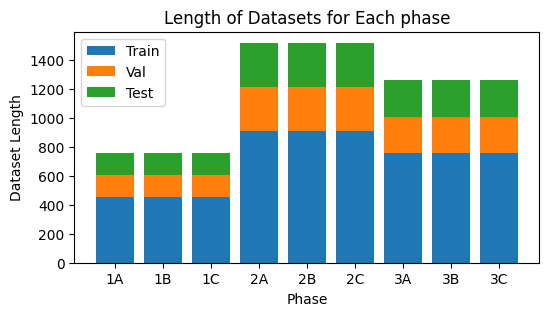

In [17]:
from matplotlib import pyplot as plt
step = []  # 1A, 1B, 1C, 2A, 2B, 2C, 3A, 3B, 3C
train_lengths = []  
val_lengths = []  
test_lengths = []  

for phase in data_handler.dataloaders:
    step.append(phase)
    train_lengths.append(len(data_handler.dataloaders[phase]["train"].dataset))
    val_lengths.append(len(data_handler.dataloaders[phase]["val"].dataset))
    test_lengths.append(len(data_handler.dataloaders[phase]["test"].dataset))

plt.figure(figsize=(6, 3))
train_bars = plt.bar(step, train_lengths, label='Train')
val_bars = plt.bar(step, val_lengths, label='Val', bottom=train_lengths)
test_bars = plt.bar(step, test_lengths, label='Test', bottom=np.array(train_lengths) + np.array(val_lengths))

plt.ylabel('Dataset Length')
plt.xlabel('Phase')
plt.legend()

plt.title('Length of Datasets for Each phase')
plt.show()


In [18]:
# 3B train 데이터셋의 150번째 데이터 시각화
print(data_handler.dataloaders["3B"]["train"])  
print(len(data_handler.dataloaders["3B"]["train"].dataset))  # 756
print(len(data_handler.dataloaders["3B"]["train"].dataset[100])) # data, label이 있있음
print(data_handler.dataloaders["3B"]["train"].dataset[150][0]) # [0]은 data, [1]은 label
print(data_handler.dataloaders["3B"]["train"].dataset[150][0].shape)

756
2
tensor([[-0.0773, -0.0803, -0.0927,  ..., -0.0991, -0.1144, -0.1094]])
torch.Size([1, 2048])


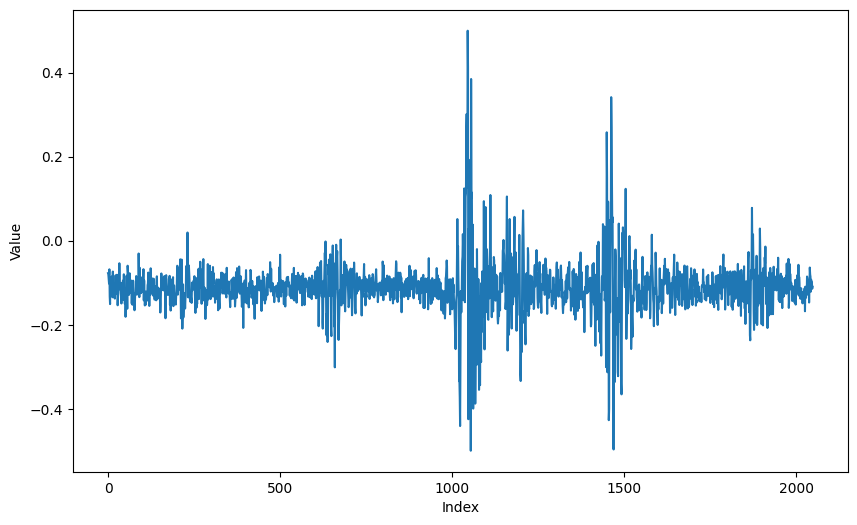

In [19]:
data = data_handler.dataloaders["3B"]["train"].dataset[150][0]

plt.figure(figsize=(10, 6))
plt.plot(data[0])  # Assume the data is 1D after removing the first dimension
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()


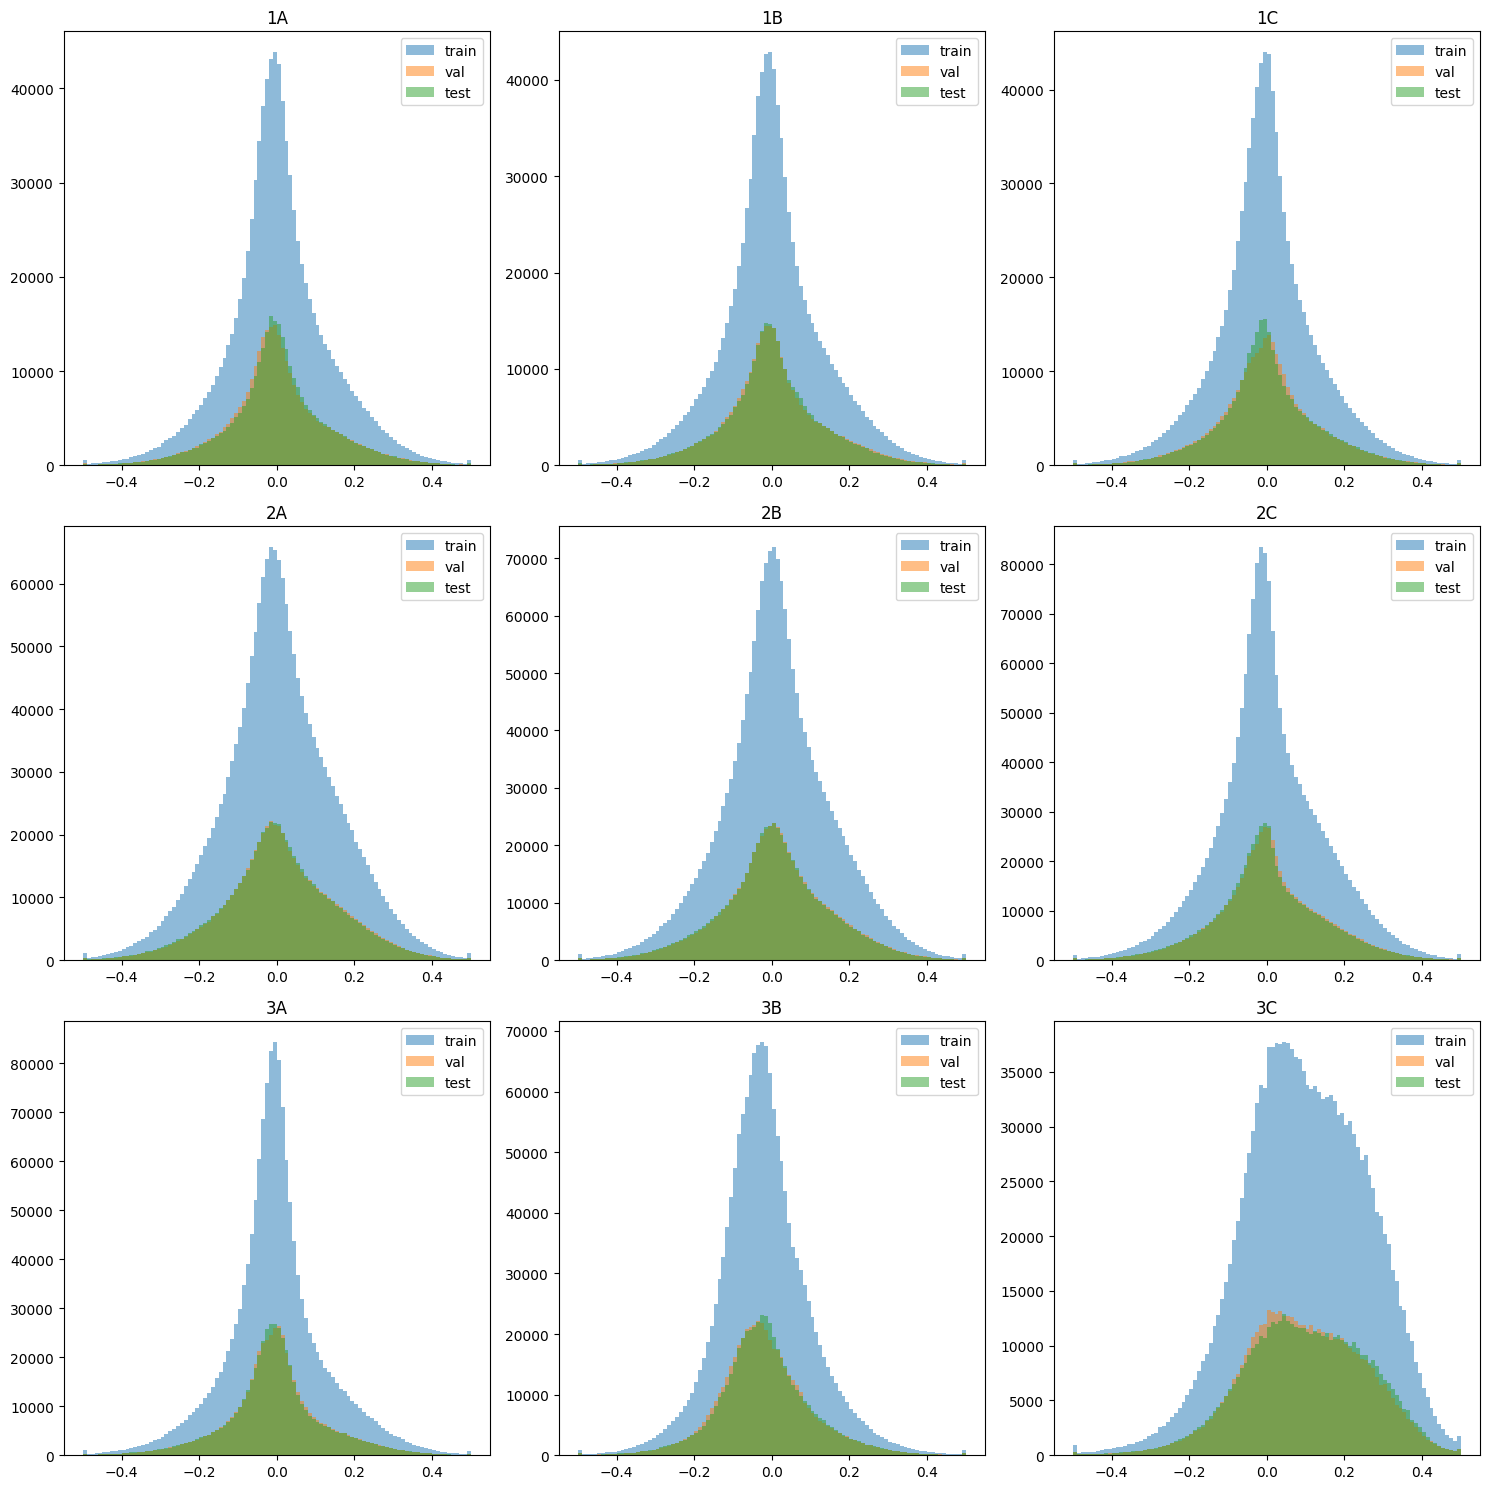

In [23]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

for i, step in enumerate(data_handler.dataloaders.keys()): # step은 1A, 1B, 1C, 2A, 2B, 2C, 3A, 3B, 3C
    for split in data_handler.dataloaders[step]: #split은 train, val, test
        data = []
        for sample, _ in data_handler.dataloaders[step][split]: # sample은 data, _는 label
            data.extend(sample.flatten().tolist())
        
        axes[i // 3][i % 3].hist(data, bins=100, alpha=0.5, label=split)
    
    axes[i // 3][i % 3].set_title(step)
    axes[i // 3][i % 3].legend()

plt.tight_layout()
plt.show()


## 모델 가져오기

모델은 아주 간단하게 가져올 수 있다. dfb의 model 폴더에 있는 모델을 아무거나 가져오면 된다.

In [20]:
from dfb.model.wdcnn2 import *

## Continual Learning

여기서부터 continual learning을 해보자!

In [21]:
import avalanche
import json

from avalanche.benchmarks.generators import dataset_benchmark
from avalanche.benchmarks.utils import make_classification_dataset
from torch.optim import SGD, Adam
from torch.nn import CrossEntropyLoss
import torch.nn as nn
from avalanche.training.supervised import JointTraining, Naive, CWRStar, Replay, GDumb, Cumulative, LwF, GEM, EWC, AGEM
from avalanche.evaluation.metrics import forgetting_metrics, \
accuracy_metrics, loss_metrics, timing_metrics, cpu_usage_metrics, \
confusion_matrix_metrics, bwt_metrics, disk_usage_metrics
from avalanche.logging import InteractiveLogger, TextLogger
from avalanche.training.plugins import EvaluationPlugin, EarlyStoppingPlugin, ReplayPlugin, \
    CWRStarPlugin, GEMPlugin, LwFPlugin, EWCPlugin



print(avalanche.__version__)

2023-08-21 15:37:27.490873: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-21 15:37:27.983462: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


0.3.1


/home/kyjub/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
def classes_in_level(level):
    if level == 1:
        return 10
    elif level == 2:
        return 4
    elif level == 3:
        return 3

In [24]:
class CLExperiment:
    
    def __init__(self, opt) -> None:

        self.opt = opt
        self.data_handler = data_handler
        self.avg_results = []

    def get_attr(self, name: str):
        if hasattr(self.opt, name):
            return getattr(self.opt, name)
        else:
            return None

    def _make_benchmark_with_level(self, data_handler: DatasetHandler, level: int):

        assert level in [1, 2, 3], "Benchmark level must be one of (1, 2, 3)"

        train_set_list = [data_handler.dataloaders[f'{level}{task}']['train'].dataset for task in ('A', 'B', 'C')]
        test_set_list = [data_handler.dataloaders[f'{level}{task}']['test'].dataset for task in ('A', 'B', 'C')]

        # 'make_classification_dataset' requires that the dataset has an attribute named 'targets'
        for train_set, test_set in zip(train_set_list, test_set_list):
            setattr(train_set, 'targets', train_set.label)
            setattr(test_set, 'targets', test_set.label)

        # AvalancheDatasets with task labels
        train_set_list = [make_classification_dataset(dataset, task_labels=idx) for idx, dataset in enumerate(train_set_list)]
        test_set_list = [make_classification_dataset(dataset, task_labels=idx) for idx, dataset in enumerate(test_set_list)]

        # Compose benchmark
        self.scenario = dataset_benchmark(
            train_set_list,
            test_set_list
        )

    def initialize(self, model, scenario=None, optimizer=None, criterion=None, eval_plugin=None):
        
        self.model = model
        level = self.get_attr('level')

        if not scenario:
            self._make_benchmark_with_level(self.data_handler, level)
        else:
            self.scenario = scenario

        self._initialize_trainig_stuff(self.model, optimizer, criterion)
        self._initialize_cl_strategy(eval_plugin)


    def _initialize_trainig_stuff(self, model: nn.Module, optimizer=None, criterion=None):

        lr = self.get_attr('lr')
        momentum = self.get_attr('momentum')
        weight_decay = self.get_attr('weight_decay')

        if not optimizer:
            optimizer = SGD(
                model.parameters(), lr=lr,
                momentum=momentum, weight_decay=weight_decay
            )
        self.optimizer = optimizer

        if not criterion:
            criterion = CrossEntropyLoss()
        self.criterion = criterion

    def _initialize_cl_strategy(self, eval_plugin):

        if not eval_plugin:
            eval_plugin = EvaluationPlugin(
                accuracy_metrics(epoch=True, experience=True, stream=True),
                loss_metrics(epoch=True, experience=True, stream=True),
                forgetting_metrics(experience=True, stream=True),
                bwt_metrics(experience=True, stream=True),   ## 최근에 추가된 metric
                timing_metrics(epoch=True, epoch_running=True), ## 최근에 추가된 metric
                disk_usage_metrics(experience=True, stream=True), ## 최근에 추가된 metric
                loggers=self._initialize_loggers(self.get_attr('interactive'))
            )

        cl_type = self.get_attr('strategy').lower()

        common_args = dict(
            model=self.model,
            optimizer=self.optimizer,
            criterion=self.criterion,
            train_epochs=self.get_attr('epoch'),
            train_mb_size=self.get_attr('batch_size'),
            eval_mb_size=self.get_attr('batch_size'),
            device=self.get_attr('device'),
            evaluator=eval_plugin
        )

        if cl_type == 'naive':
            self.strategy = Naive(**common_args)
        elif cl_type == 'replay':
            self.strategy = Replay(
                **common_args,
                mem_size=self.get_attr('memory_size')
            )
        elif cl_type == 'joint':
            self.strategy = JointTraining(**common_args)
        elif cl_type == 'cumulative':
            self.strategy = Cumulative(**common_args)

        elif cl_type == 'cwrstar':
            self.strategy = CWRStar(
                cwr_layer_name='conv_layers',   ####### WDCNN2 아키텍처 기준
                **common_args
            )
        elif cl_type == 'gdumb':
            self.strategy = GDumb(
                **common_args
            )
        elif cl_type == 'lwf':
            self.strategy = LwF(
                alpha=self.get_attr('alpha4lwf'),  # 0 과 1 사이의 값. 낮을수록 이전 task 지식 유지
                temperature=1.2, 
                **common_args
            )
        elif cl_type == 'gem':
            self.strategy = GEM(
                patterns_per_exp=self.get_attr('patterns_per_exp4gem'),  # len(data_handler.dataloaders["3B"]["train"].dataset)=756
                memory_strength=self.get_attr('memory_strength4gem'),  # 0 과 1 사이의 값. 높을수록 이전 task 지식 유지
                **common_args
            )
        elif cl_type == 'ewc':
            self.strategy = EWC(
                ewc_lambda=1e-2,  # 1e-2 ~1e-4 사이의 값.
                **common_args
            )
        else:
            raise NotImplementedError(f"CL strategy '{cl_type}' has not been implemented yet!!!")


    def _make_param_string(self):
        model_name = type(self.model).__name__
        level = str(self.get_attr('level'))
        strategy = self.get_attr('strategy')
        
        optimizer = type(self.optimizer).__name__
        lr = self.get_attr('lr')
        weight_decay = self.get_attr('weight_decay')
        momentum = self.get_attr('momentum')

        if strategy.lower() == 'lwf':
            Alpha = self.get_attr('alpha4lwf')
            return f'{model_name}_level_{level}_{strategy}_alpha={Alpha}'
        elif strategy.lower() == 'gem':
            patterns_per_exp = self.get_attr('patterns_per_exp4gem')
            memory_strength = self.get_attr('memory_strength4gem')
            return f'{model_name}_level_{level}_{strategy}_patterns_per_exp={patterns_per_exp}_memory_strength={memory_strength}'
        elif strategy.lower() == 'replay':
            memory_size = self.get_attr('memory_size')
            return f'{model_name}_level_{level}_{strategy}_memory_size={memory_size}'
        else:
            return f'{model_name}_level_{level}_{strategy}_{optimizer}_lr_{lr}_momentum_{momentum}_l2_reg_{weight_decay}'
        

    def _make_log_path(self):
        save_folder = self.get_attr('save_folder_name')
        os.makedirs(save_folder, exist_ok=True)
        log_path = os.path.join(save_folder, self._make_param_string() + '.log')  
        return log_path

    def _initialize_loggers(self, interactive=True, text=True,):
        loggers = []
        if interactive:
            loggers.append(InteractiveLogger())
        if text:
            log_path = self._make_log_path()
            loggers.append(TextLogger(open(log_path, 'a')))
        self.loggers = loggers
        return self.loggers


    def _get_exp_metric_key(self, metric: str, phase: str, task: int, exp: int=None):

        if not exp:
            exp = task

        if metric.lower() == 'acc':
            header = 'Top1_Acc_Exp'
        elif metric.lower() == 'loss':
            header = 'Loss_Exp'
        elif metric.lower() == 'forgetting':
            header = 'ExperienceForgetting'

        return f'{header}/{phase}_phase/test_stream/Task{task:>03d}/Exp{exp:>03d}'


    def _get_metrics_for_joint(self, result):
        metrics = dict()
        avg_accuracy = [result[-1][self._get_exp_metric_key('acc', 'eval', task)] for task in range(3)]
        avg_forgetting = [result[-1][self._get_exp_metric_key('forgetting', 'eval', task)] for task in range(3)]

        metrics['avg_accuracy'] = avg_accuracy
        metrics['avg_forgetting'] = avg_forgetting

        return metrics


    def _get_avg_metrics(self, result):
        if self.get_attr('strategy').lower() == 'joint':
            return self._get_metrics_for_joint()

        num_tasks = len(result)

        metrics = dict()
        avg_accuracy = []
        avg_forgetting = []
        for current in range(num_tasks):
            accuracies = [result[current][self._get_exp_metric_key('acc', 'eval', past)] for past in range(current+1)]
            forgettings = [result[current][self._get_exp_metric_key('forgetting', 'eval', past)] for past in range(current)]

            avg_accuracy.append(np.mean(accuracies))
            if forgettings:
                avg_forgetting.append(np.mean(forgettings))
            else:
                avg_forgetting.append(0)

        metrics['avg_accuracy'] = avg_accuracy
        metrics['avg_forgetting'] = avg_forgetting

        return metrics


    def _get_text_logger(self):

        for logger in self.loggers:
            if isinstance(logger, TextLogger):
                return logger
        return None
    

    def _append_results(self, results):
        avg_metrics = self._get_avg_metrics(results)
        self.avg_results.append(avg_metrics)
        
        print(avg_metrics)

        text_logger = self._get_text_logger()
        if text_logger:
            print(avg_metrics, file=text_logger.file, flush=True)

    def save_results(self, filename=None):
        if not filename:
            filename = self._make_param_string() + '_results.json'
        
        save_folder = self.get_attr('save_folder_name')
        os.makedirs(save_folder, exist_ok=True)
        
        filepath = os.path.join(save_folder, filename)
        json.dump(self.avg_results, open(filepath, 'w'), indent=4)


    def get_best_result(self):

        final_avg_acc = [metrics['avg_accuracy'][-1] for metrics in self.avg_results]
        best_result_idx = np.argmax(final_avg_acc)
        
        return best_result_idx, self.avg_results[best_result_idx]


    def _execute_joint_training(self):

        results = []

        self.strategy.train(self.scenario.train_stream)
        results.append(self.strategy.eval(self.scenario.test_stream))
        
        self._append_results(results)


    def _execute(self):

        results = []
        
        for exp in self.scenario.train_stream:
            self.strategy.train(exp)
            results.append(self.strategy.eval(self.scenario.test_stream))

        self._append_results(results)


    def execute(self, exec_id=0):
        for logger in self.loggers:
            if isinstance(logger, TextLogger):
                print(f"Start execution {exec_id}!!!", file=logger.file, flush=True)

        if self.get_attr('strategy') == 'joint':
            self._execute_joint_training()
        else:
            self._execute()

        

In [40]:
import argparse

parser = argparse.ArgumentParser()

parser.add_argument(
    '--level',
    type=int,
    choices=[1, 2, 3],
    default=1
)
parser.add_argument(
    '--repeat',
    type=int,
    default=50
)
parser.add_argument(
    '--strategy',
    type=str,
    default='Naive'
)
parser.add_argument(
    '--lr',
    type=float,
    default=0.01, 
)
parser.add_argument(
    '--momentum',
    type=float,
    default=0
)
parser.add_argument(
    '--l2',
    type=float,
    dest='weight_decay',
    default=0.01,
)
parser.add_argument(
    '--device',
    choices=['cuda', 'cpu'],
    default='cuda',
)
parser.add_argument(
    '--batch-size',
    type=int,
    default=64,
)
parser.add_argument(
    '--epoch',
    type=int,
    default=200,  # 50에서 200으로 변경
)
parser.add_argument(
    '--memory-size',
    type=int,
    default=200,
)
parser.add_argument(
    '--interactive',
    type=bool,
    default=False
)
parser.add_argument(
    '--save_folder_name',
    type=str,
    default='.'
)
parser.add_argument(  #####################
    '--alpha4lwf',
    type=float,
    default=0,
)
parser.add_argument(  #####################
    '--patterns_per_exp4gem', # 
    type=int,
    default=756,
)
parser.add_argument(  #####################
    '--memory_strength4gem',   # 0 과 1 사이의 값
    type=float,
    default=0.3,
)


_StoreAction(option_strings=['--memory_strength4gem'], dest='memory_strength4gem', nargs=None, const=None, default=0.3, type=<class 'float'>, choices=None, required=False, help=None, metavar=None)

In [41]:
def start_experiment(opt):

    cl_experiment = CLExperiment(opt)

    repeat = cl_experiment.get_attr('repeat')
    level = cl_experiment.get_attr('level')

    for idx in range(repeat):
        model = WDCNN2(n_classes=classes_in_level(level))

        cl_experiment.initialize(model) 
        cl_experiment.execute(idx)

    cl_experiment.save_results()


## GEM 실험

In [55]:
strategy = 'gem'
level = '3'
total_sample = len(data_handler.dataloaders["3A"]["train"].dataset) 
print('total_sample:',total_sample)
patterns_per_exp = [int(total_sample * 0.1), int(100), int(total_sample * 0.2), int(200) ]
patterns_per_exp = [int(100), int(150), int(200)]
print('patterns_per_exp:',patterns_per_exp)
ms = 0.1

total_sample: 756
patterns_per_exp: [100, 150, 200]


In [43]:
# GEM 실험
from tqdm import tqdm

for patterns in tqdm(patterns_per_exp, desc='Patterns per Experience'):
    print(f'### Level {level}, Strategy {strategy} , Patterns per Experience {patterns}, Memory Strength {ms} ###')
    opt_list = [
        '--repeat', str(10),   
        '--level', str(level),
        '--strategy', strategy,
        '--patterns_per_exp4gem', str(patterns),
        '--memory_strength', str(ms),
        '--save_folder_name', generate_save_folder_name(model_name, strategy, patterns_per_exp=patterns, memory_strength=ms),
    ]
    opt = parser.parse_args(opt_list)
    start_experiment(opt)


Patterns per Experience:   0%|          | 0/3 [00:00<?, ?it/s]

### Level 3, Strategy gem , Patterns per Experience 100, Memory Strength 0.1 ###
@@@ strategy:gem
{'avg_accuracy': [0.996031746031746, 0.8333333333333333, 0.8835978835978836], 'avg_forgetting': [0, 0.1706349206349207, 0.05357142857142855]}
{'avg_accuracy': [1.0, 0.9067460317460317, 0.9021164021164022], 'avg_forgetting': [0, 0.11111111111111116, 0.08531746031746035]}
{'avg_accuracy': [0.9920634920634921, 0.9246031746031746, 0.8941798941798943], 'avg_forgetting': [0, 0.09126984126984128, 0.1111111111111111]}
{'avg_accuracy': [0.996031746031746, 0.9087301587301587, 0.8835978835978836], 'avg_forgetting': [0, 0.13095238095238093, 0.09920634920634919]}
{'avg_accuracy': [0.9920634920634921, 0.8511904761904762, 0.8624338624338623], 'avg_forgetting': [0, 0.19841269841269848, 0.12698412698412703]}
{'avg_accuracy': [0.9880952380952381, 0.9464285714285714, 0.8955026455026456], 'avg_forgetting': [0, 0.05555555555555558, 0.11706349206349209]}
{'avg_accuracy': [0.9920634920634921, 0.8630952380952381,

Patterns per Experience:  33%|███▎      | 1/3 [16:45<33:31, 1005.91s/it]

{'avg_accuracy': [0.9920634920634921, 0.9404761904761905, 0.8809523809523809], 'avg_forgetting': [0, 0.04761904761904767, 0.11706349206349209]}
### Level 3, Strategy gem , Patterns per Experience 150, Memory Strength 0.1 ###
@@@ strategy:gem
{'avg_accuracy': [0.9880952380952381, 0.878968253968254, 0.884920634920635], 'avg_forgetting': [0, 0.15476190476190477, 0.09325396825396831]}
{'avg_accuracy': [0.9920634920634921, 0.8948412698412698, 0.8730158730158729], 'avg_forgetting': [0, 0.10317460317460325, 0.11309523809523814]}
{'avg_accuracy': [0.996031746031746, 0.9464285714285714, 0.9100529100529101], 'avg_forgetting': [0, 0.05555555555555558, 0.08730158730158727]}
{'avg_accuracy': [0.9920634920634921, 0.873015873015873, 0.8875661375661376], 'avg_forgetting': [0, 0.1785714285714286, 0.1071428571428572]}
{'avg_accuracy': [0.9920634920634921, 0.9087301587301587, 0.8862433862433864], 'avg_forgetting': [0, 0.12698412698412698, 0.12103174603174599]}
{'avg_accuracy': [0.996031746031746, 0.90079

Patterns per Experience:  67%|██████▋   | 2/3 [33:44<16:53, 1013.27s/it]

{'avg_accuracy': [0.996031746031746, 0.9543650793650793, 0.8994708994708994], 'avg_forgetting': [0, 0.04761904761904767, 0.0892857142857143]}
### Level 3, Strategy gem , Patterns per Experience 200, Memory Strength 0.1 ###
@@@ strategy:gem
{'avg_accuracy': [0.9920634920634921, 0.9821428571428572, 0.8558201058201057], 'avg_forgetting': [0, 0.0, 0.14087301587301593]}
{'avg_accuracy': [0.9920634920634921, 0.9623015873015872, 0.9153439153439153], 'avg_forgetting': [0, 0.039682539682539764, 0.09523809523809523]}
{'avg_accuracy': [0.9920634920634921, 0.9543650793650793, 0.8677248677248678], 'avg_forgetting': [0, 0.04761904761904767, 0.128968253968254]}
{'avg_accuracy': [0.9920634920634921, 0.9682539682539683, 0.8518518518518517], 'avg_forgetting': [0, 0.02777777777777779, 0.128968253968254]}
{'avg_accuracy': [0.996031746031746, 0.9583333333333333, 0.8902116402116403], 'avg_forgetting': [0, 0.031746031746031744, 0.12499999999999994]}
{'avg_accuracy': [0.9880952380952381, 0.878968253968254, 0.

Patterns per Experience: 100%|██████████| 3/3 [51:10<00:00, 1023.58s/it]

{'avg_accuracy': [0.9920634920634921, 0.9345238095238095, 0.8796296296296297], 'avg_forgetting': [0, 0.08730158730158732, 0.14087301587301587]}


['1', '2', '3']
[[0.99365079 0.90119048 0.87804233]]
['1', '2', '3']
[[0.99285714 0.90992063 0.88915344]]
['1', '2', '3']
[[0.99246032 0.9422619  0.86851852]]


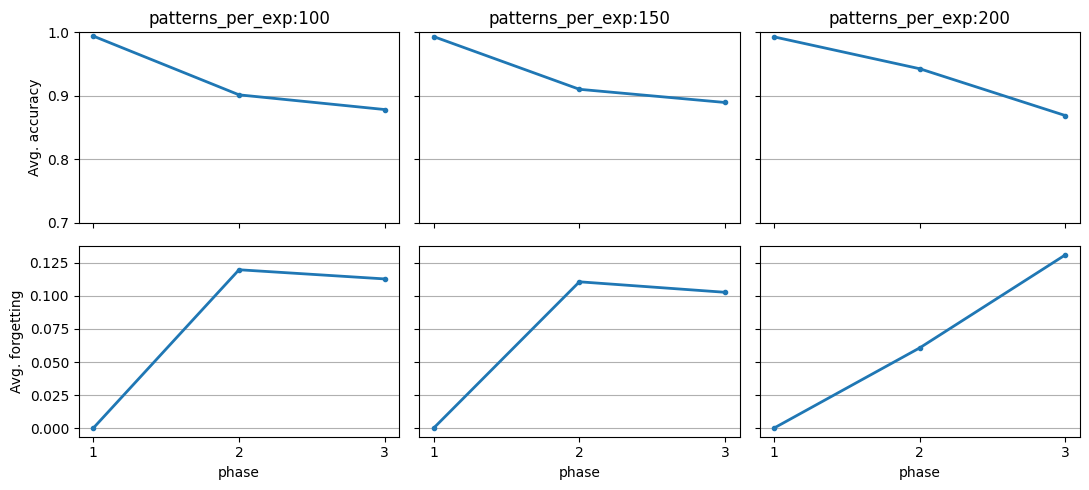

In [56]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 3, sharex='all', sharey='row', figsize=(11, 5))
for i, pattern in enumerate(patterns_per_exp):
    results = [json.load(open(f"WDCNN2_GEM_ppe:{pattern}_ms:{ms}_0821/WDCNN2_level_3_gem_patterns_per_exp={pattern}_memory_strength={ms}_results.json", 'r'))]

    avg_accs = []
    avg_forgetting = []
    for result in results:
        avg_accs.append([metric['avg_accuracy'] for metric in result])
        avg_forgetting.append([metric['avg_forgetting'] for metric in result])
    
    mean_accs = np.mean(avg_accs, axis=1)
    mean_forgetting = np.mean(avg_forgetting, axis=1)

    avg_plot_args = []
    forgetting_plot_args = []
    x = ['1', '2', '3']
    
    print(x)
    print(mean_accs)

    avg_plot_args.append(x)
    avg_plot_args.append(mean_accs[0]) 
    avg_plot_args.append('-o')

    forgetting_plot_args.append(x)
    forgetting_plot_args.append(mean_forgetting[0]) 
    forgetting_plot_args.append('-o') 

    axes[0][i].plot(*avg_plot_args, markersize=3, linewidth=2)  
    axes[0][i].set_title(f"patterns_per_exp:{pattern}")
    if i == 0:
        axes[0][i].set_ylabel("Avg. accuracy")
    axes[0][i].set_ylim(0.7, 1.)
    axes[0][i].grid(True, axis='y')

    axes[1][i].plot(*forgetting_plot_args, markersize=3, linewidth=2)
    if i == 0:
        axes[1][i].set_ylabel("Avg. forgetting")
    axes[1][i].set_xlabel("phase")
    axes[1][i].grid(True, axis='y')
    
plt.tight_layout()
plt.savefig(f'strategy_results_graph.png', dpi=300, bbox_inches='tight')

## Replay 실험

In [48]:
strategy2 = 'replay'
level = '3'
total_sample = len(data_handler.dataloaders["3A"]["train"].dataset) 
print('total_sample:',total_sample)
memory_size = [int(total_sample * 0.1),int(100) , int(total_sample * 0.2) ,int(200) ]
memory_size = [int(100), int(150) ,int(200)]
memory_size = [int(100), int(150)]
print('patterns_per_exp:',memory_size)

total_sample: 756
patterns_per_exp: [100, 150]


In [47]:
# Replay 실험
from tqdm import tqdm

for ms in tqdm(memory_size, desc='Patterns per Experience'):
    print(f'### Level {level}, Strategy {strategy2} memory_size {ms}###')
    opt_list = [
        '--repeat', str(10),
        '--level', str(level),
        '--strategy', strategy2,
        '--memory-size', str(ms),
        '--save_folder_name', generate_save_folder_name(model_name, strategy2, memory_size=ms),
    ]
    opt = parser.parse_args(opt_list)
    start_experiment(opt)

Patterns per Experience:   0%|          | 0/3 [00:00<?, ?it/s]

### Level 3, Strategy replay memory_size 100###
@@@ strategy:replay
{'avg_accuracy': [0.996031746031746, 0.9781746031746031, 0.9087301587301587], 'avg_forgetting': [0, 0.015873015873015928, 0.10714285714285715]}
{'avg_accuracy': [0.9920634920634921, 0.9841269841269842, 0.9325396825396824], 'avg_forgetting': [0, 0.0, 0.0753968253968254]}
{'avg_accuracy': [0.996031746031746, 0.9801587301587302, 0.921957671957672], 'avg_forgetting': [0, 0.007936507936507908, 0.0892857142857143]}
{'avg_accuracy': [0.9841269841269841, 0.9682539682539681, 0.9431216931216931], 'avg_forgetting': [0, 0.0, 0.037698412698412676]}
{'avg_accuracy': [0.9920634920634921, 0.9583333333333334, 0.9166666666666666], 'avg_forgetting': [0, 0.0357142857142857, 0.09126984126984128]}
{'avg_accuracy': [0.9880952380952381, 0.9821428571428571, 0.9126984126984127], 'avg_forgetting': [0, 0.00793650793650802, 0.10119047619047622]}
{'avg_accuracy': [0.9880952380952381, 0.9702380952380952, 0.9298941798941799], 'avg_forgetting': [0, 0.

Patterns per Experience:  33%|███▎      | 1/3 [11:42<23:24, 702.47s/it]

{'avg_accuracy': [0.996031746031746, 0.9781746031746031, 0.9338624338624338], 'avg_forgetting': [0, 0.011904761904761973, 0.07341269841269843]}
### Level 3, Strategy replay memory_size 150###
@@@ strategy:replay
{'avg_accuracy': [0.9920634920634921, 0.9801587301587302, 0.9417989417989419], 'avg_forgetting': [0, 0.0, 0.05555555555555558]}
{'avg_accuracy': [0.996031746031746, 0.9821428571428572, 0.9444444444444445], 'avg_forgetting': [0, 0.0, 0.051587301587301626]}
{'avg_accuracy': [0.996031746031746, 0.9801587301587302, 0.9298941798941799], 'avg_forgetting': [0, 0.0, 0.07341269841269843]}
{'avg_accuracy': [0.996031746031746, 0.9841269841269841, 0.9246031746031745], 'avg_forgetting': [0, 0.011904761904761973, 0.07936507936507936]}
{'avg_accuracy': [0.9920634920634921, 0.9801587301587302, 0.9444444444444445], 'avg_forgetting': [0, -0.003968253968253954, 0.05357142857142855]}
{'avg_accuracy': [0.996031746031746, 0.9722222222222222, 0.921957671957672], 'avg_forgetting': [0, 0.02380952380952

Patterns per Experience:  67%|██████▋   | 2/3 [23:12<11:35, 695.31s/it]

{'avg_accuracy': [0.9920634920634921, 0.9742063492063492, 0.9312169312169312], 'avg_forgetting': [0, 0.019841269841269882, 0.06944444444444448]}
### Level 3, Strategy replay memory_size 200###
@@@ strategy:replay


Patterns per Experience:  67%|██████▋   | 2/3 [23:16<11:38, 698.07s/it]


KeyboardInterrupt: 

['1', '2', '3']
[[0.99126984 0.97321429 0.9234127 ]]
['1', '2', '3']
[[0.99484127 0.9781746  0.93664021]]


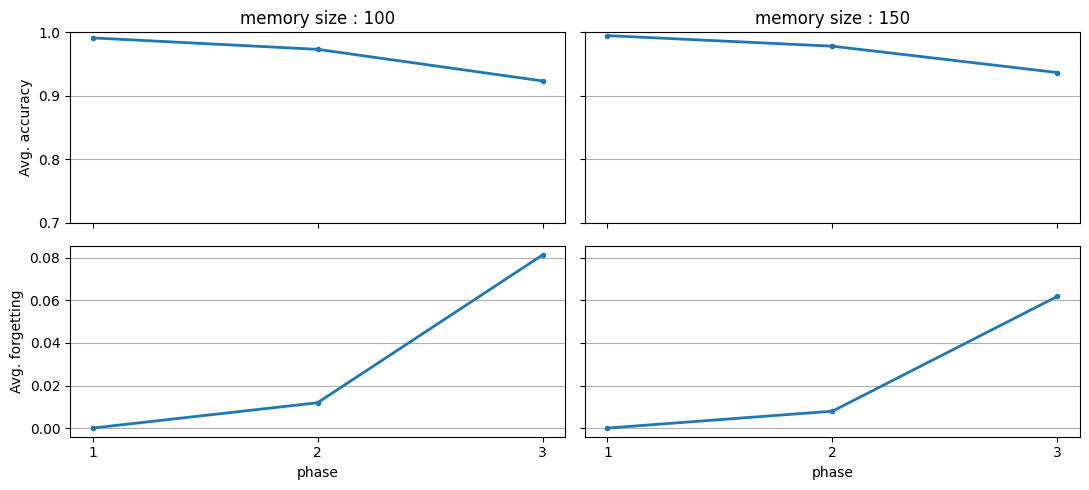

In [53]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2, sharex='all', sharey='row', figsize=(11, 5))
for i, ms in enumerate(memory_size):
    results = [json.load(open(f"WDCNN2_REPLAY_memory_size:{ms}_0821/WDCNN2_level_3_replay_memory_size={ms}_results.json", 'r'))]

    avg_accs = []
    avg_forgetting = []
    for result in results:
        avg_accs.append([metric['avg_accuracy'] for metric in result])
        avg_forgetting.append([metric['avg_forgetting'] for metric in result])
    
    mean_accs = np.mean(avg_accs, axis=1)
    mean_forgetting = np.mean(avg_forgetting, axis=1)

    avg_plot_args = []
    forgetting_plot_args = []
    x = ['1', '2', '3']
    
    print(x)
    print(mean_accs)

    avg_plot_args.append(x)
    avg_plot_args.append(mean_accs[0]) ########
    avg_plot_args.append('-o')

    forgetting_plot_args.append(x)
    forgetting_plot_args.append(mean_forgetting[0]) ########
    forgetting_plot_args.append('-o') 

    axes[0][i].plot(*avg_plot_args, markersize=3, linewidth=2)  
    axes[0][i].set_title(f"memory size : {ms}")
    if i == 0:
        axes[0][i].set_ylabel("Avg. accuracy")
    axes[0][i].set_ylim(0.7, 1.)
    axes[0][i].grid(True, axis='y')

    axes[1][i].plot(*forgetting_plot_args, markersize=3, linewidth=2)
    if i == 0:
        axes[1][i].set_ylabel("Avg. forgetting")
    axes[1][i].set_xlabel("phase")
    axes[1][i].grid(True, axis='y')
    
plt.tight_layout()
plt.savefig(f'strategy_results_graph.png', dpi=300, bbox_inches='tight')

## GEM 전체 메모리 사용 실험

In [58]:
strategy = 'gem'
level = '3'
total_sample = len(data_handler.dataloaders["3A"]["train"].dataset) 
print('total_sample:',total_sample)
patterns_per_exp = int(total_sample)
print('patterns_per_exp:',patterns_per_exp)
ms = 0.1

total_sample: 756
patterns_per_exp: 756


In [59]:
# GEM 실험
print(f'### Level {level}, Strategy {strategy} , Patterns per Experience 756, Memory Strength {ms} ###')
opt_list = [
    '--repeat', str(10),   
    '--level', str(level),
    '--strategy', strategy,
    '--patterns_per_exp4gem', str(patterns_per_exp),
    '--memory_strength', str(ms),
    '--save_folder_name', generate_save_folder_name(model_name, strategy, patterns_per_exp=patterns_per_exp, memory_strength=ms),
]
opt = parser.parse_args(opt_list)
start_experiment(opt)

### Level 3, Strategy gem , Patterns per Experience 756, Memory Strength 0.1 ###
@@@ strategy:gem
{'avg_accuracy': [0.996031746031746, 0.9305555555555556, 0.9232804232804233], 'avg_forgetting': [0, 0.08333333333333337, 0.0714285714285714]}
{'avg_accuracy': [0.9920634920634921, 0.8849206349206349, 0.8862433862433862], 'avg_forgetting': [0, 0.15476190476190477, 0.09325396825396826]}
{'avg_accuracy': [0.9920634920634921, 0.9722222222222222, 0.8492063492063492], 'avg_forgetting': [0, 0.00793650793650802, 0.16071428571428575]}
{'avg_accuracy': [0.9920634920634921, 0.9662698412698412, 0.8994708994708994], 'avg_forgetting': [0, 0.00793650793650802, 0.07738095238095238]}
{'avg_accuracy': [0.996031746031746, 0.9226190476190477, 0.9034391534391535], 'avg_forgetting': [0, 0.04365079365079372, 0.05753968253968256]}
{'avg_accuracy': [1.0, 0.9642857142857143, 0.8359788359788359], 'avg_forgetting': [0, 0.0357142857142857, 0.15873015873015872]}
{'avg_accuracy': [0.996031746031746, 0.9384920634920635, 

['1', '2', '3']
[[0.99444444 0.9452381  0.88531746]]


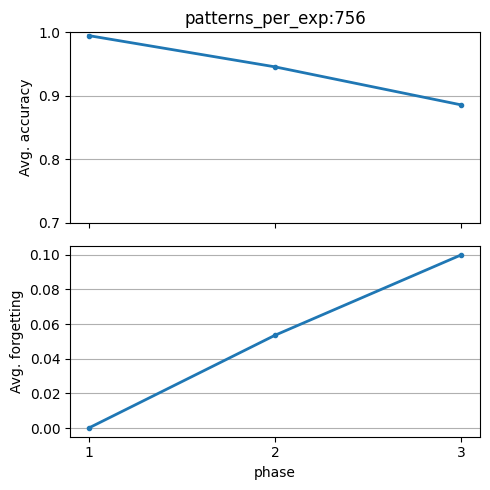

In [65]:
import matplotlib.pyplot as plt
import numpy as np
import json

patterns_per_exp = [int(total_sample)]  # 단일 값을 포함

fig, axes = plt.subplots(2, 1, sharex='all', figsize=(5, 5))
pattern = patterns_per_exp[0]

results = [json.load(open(f"WDCNN2_GEM_ppe:{pattern}_ms:{ms}_0821/WDCNN2_level_3_gem_patterns_per_exp={pattern}_memory_strength={ms}_results.json", 'r'))]

avg_accs = []
avg_forgetting = []
for result in results:
    avg_accs.append([metric['avg_accuracy'] for metric in result])
    avg_forgetting.append([metric['avg_forgetting'] for metric in result])

mean_accs = np.mean(avg_accs, axis=1)
mean_forgetting = np.mean(avg_forgetting, axis=1)

x = ['1', '2', '3']

print(x)
print(mean_accs)

axes[0].plot(x, mean_accs[0], '-o', markersize=3, linewidth=2)  
axes[0].set_title(f"patterns_per_exp:{pattern}")
axes[0].set_ylabel("Avg. accuracy")
axes[0].set_ylim(0.7, 1.)
axes[0].grid(True, axis='y')

axes[1].plot(x, mean_forgetting[0], '-o', markersize=3, linewidth=2)
axes[1].set_ylabel("Avg. forgetting")
axes[1].set_xlabel("phase")
axes[1].grid(True, axis='y')

plt.tight_layout()
plt.savefig(f'strategy_results_graph.png', dpi=300, bbox_inches='tight')


In [21]:
import matplotlib.pyplot as plt
patterns_per_exp = [int(total_sample * 0.3), int(total_sample * 0.4), int(total_sample * 0.5), int(total_sample * 0.6), int(total_sample * 0.7), int(total_sample * 0.8), int(total_sample * 0.9)]
memory_strength = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]# 0 과 1 사이의 값. 낮을수록 이전 task 지식 유지
memory_strength = [0.3, 0.5, 0.7, 0.8]# 0 과 1 사이의 값. 낮을수록 이전 task 지식 유지
# patterns_per_exp: [226, 302, 378, 453, 529, 604, 680]  ## 7개
# memory_strength:  [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]       ## 6개

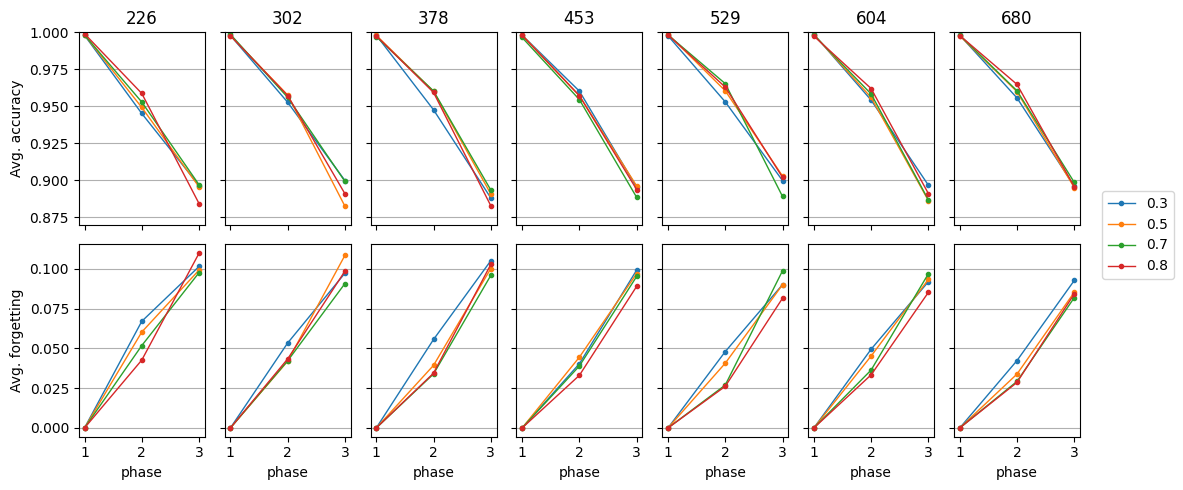

In [23]:
fig, axes = plt.subplots(2, 7, sharex='all', sharey='row', figsize=(11, 5))
for i, pattern in enumerate(patterns_per_exp):
    results = [json.load(open(f"WDCNN2_GEM_ Pattens:{pattern}_ms:{ms}_0729/WDCNN2_level_3_gem_patterns_per_exp={pattern}_memory_strength={ms}_results.json", 'r')) for ms in memory_strength]

    avg_accs = []
    avg_forgetting = []
    for result in results:
        avg_accs.append([metric['avg_accuracy'] for metric in result])
        avg_forgetting.append([metric['avg_forgetting'] for metric in result])
    
    mean_accs = np.mean(avg_accs, axis=1)
    mean_forgetting = np.mean(avg_forgetting, axis=1)

    avg_plot_args = []
    forgetting_plot_args = []
    x = ['1', '2', '3']
    for idx, strat in enumerate(memory_strength):
        avg_plot_args.append(x)
        avg_plot_args.append(mean_accs[idx])
        avg_plot_args.append('-o')

        forgetting_plot_args.append(x)
        forgetting_plot_args.append(mean_forgetting[idx])
        forgetting_plot_args.append('-o')

    axes[0][i].plot(*avg_plot_args, markersize=3, linewidth=1)  ###
    axes[0][i].set_title(f"{pattern}")
    if i == 0:
        axes[0][i].set_ylabel("Avg. accuracy")
    axes[0][i].set_ylim(0.87, 1.)
    axes[0][i].grid(True, axis='y')

    axes[1][i].plot(*forgetting_plot_args, markersize=3, linewidth=1)
    if i == 0:
        axes[1][i].set_ylabel("Avg. forgetting")
    axes[1][i].set_xlabel("phase")
    axes[1][i].grid(True, axis='y')
    
fig.legend(memory_strength, loc='center left', bbox_to_anchor=(1, 0.52))
plt.tight_layout()
plt.savefig(f'strategy_results_graph.png', dpi=300, bbox_inches='tight')

In [32]:
cumulative_results = json.load(open("WDCNN_level_3_Cumulative_SGD_lr_0.01_momentum_0_l2_reg_0.01_results.json", 'r'))
naive_results = json.load(open("WDCNN_level_3_Naive_SGD_lr_0.01_momentum_0_l2_reg_0.01_results.json", 'r'))
replay_results = json.load(open("WDCNN_level_3_Replay_SGD_lr_0.01_momentum_0_l2_reg_0.01_results.json", 'r'))

FileNotFoundError: [Errno 2] No such file or directory: 'WDCNN_level_3_Cumulative_SGD_lr_0.01_momentum_0_l2_reg_0.01_results.json'

In [ ]:
cumulative_avg_acc = np.array([metric['avg_accuracy'] for metric in cumulative_results])
naive_avg_acc = np.array([metric['avg_accuracy'] for metric in naive_results])
replay_avg_acc = np.array([metric['avg_accuracy'] for metric in replay_results])

In [ ]:
mean_cum, std_cum = np.mean(cumulative_avg_acc, axis=0), np.std(cumulative_avg_acc, axis=0)
mean_naive, std_naive = np.mean(naive_avg_acc, axis=0), np.std(naive_avg_acc, axis=0)
mean_re, std_re = np.mean(replay_avg_acc, axis=0), np.std(replay_avg_acc, axis=0)

In [26]:
### 일단 바꿈
memory_sizes = ['25', '50', '75']

FileNotFoundError: [Errno 2] No such file or directory: 'WDCNN_level_1_Replay_25_SGD_lr_0.01_momentum_0_l2_reg_0.01_results.json'

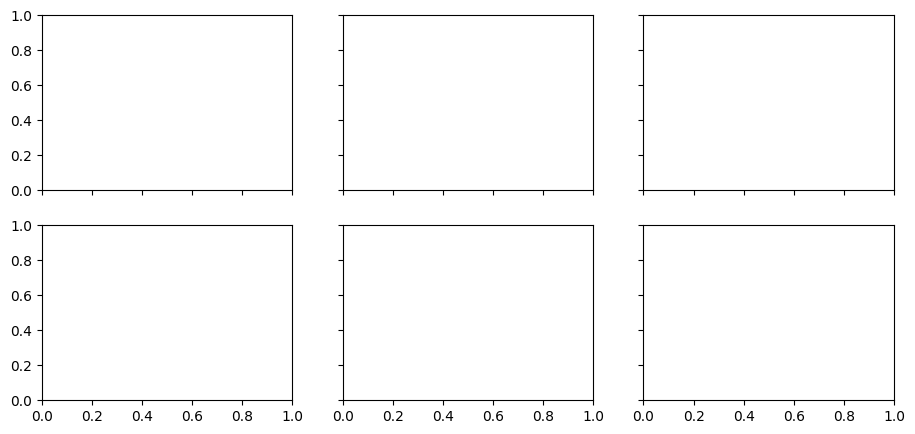

In [27]:
fig, axes = plt.subplots(2, 3, sharex='all', sharey='row', figsize=(11, 5))
for level in range(3):

    results = [json.load(open(f"WDCNN_level_{level+1}_Replay_{memory}_SGD_lr_0.01_momentum_0_l2_reg_0.01_results.json", 'r')) for memory in memory_sizes]
    results.append(json.load(open(f"WDCNN_level_{level+1}_Replay_SGD_lr_0.01_momentum_0_l2_reg_0.01_results.json", 'r')))  # 메모리 100

    avg_accs = []
    avg_forgetting = []
    for result in results:
        avg_accs.append([metric['avg_accuracy'] for metric in result])
        avg_forgetting.append([metric['avg_forgetting'] for metric in result])
    
    mean_accs = np.mean(avg_accs, axis=1)
    mean_forgetting = np.mean(avg_forgetting, axis=1)

    avg_plot_args = []
    forgetting_plot_args = []
    x = ['1', '2', '3']
    for idx, mem_size in enumerate(['25', '50', '75', '100']):
        avg_plot_args.append(x)
        avg_plot_args.append(mean_accs[idx])
        avg_plot_args.append('-^')

        forgetting_plot_args.append(x)
        forgetting_plot_args.append(mean_forgetting[idx])
        forgetting_plot_args.append('-v')

    axes[0][level].plot(*avg_plot_args, markersize=4, linewidth=3)
    axes[0][level].set_title(f"Level {level+1}")
    if level == 0:
        axes[0][level].set_ylabel("Avg. accuracy")
    axes[0][level].set_ylim(0.8, 1.)
    axes[0][level].grid(True, axis='y')

    axes[1][level].plot(*forgetting_plot_args, markersize=4, linewidth=3)
    if level == 0:
        axes[1][level].set_ylabel("Avg. forgetting")
    axes[1][level].set_xlabel("Number of tasks")
    axes[1][level].grid(True, axis='y')
    
fig.legend([f'Replay ({size})' for size in [25, 50, 75, 100]], loc='center left', bbox_to_anchor=(1, 0.52))
plt.tight_layout()
plt.savefig(f'replay_results_graph.png', dpi=300, bbox_inches='tight')

In [ ]:
x = ['1', '2', '3']

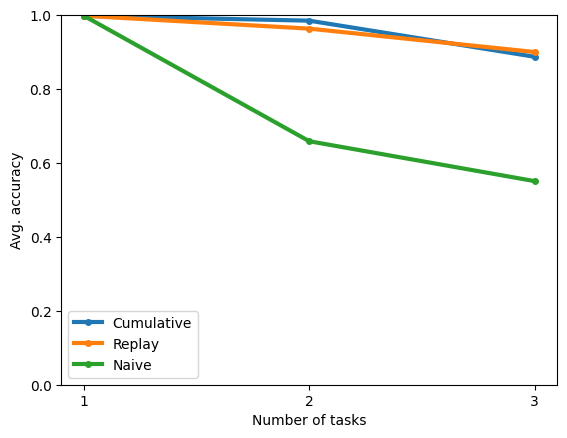

In [ ]:
plt.plot(x, mean_cum, '-o', x, mean_re, '-o', x, mean_naive, '-o', markersize=4, linewidth=3)
plt.ylabel("Avg. accuracy")
plt.ylim(0., 1.)
plt.xlabel("Number of tasks")
plt.legend(["Cumulative", "Replay", "Naive"])

In [ ]:
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu

In [ ]:
mannwhitneyu(replay_avg_acc[:, 2], cumulative_avg_acc[:, 2])

MannwhitneyuResult(statistic=1393.5, pvalue=0.32418845118821493)

((array([-2.20385432, -1.83293478, -1.61402323, -1.45296849, -1.32267759,
         -1.21163342, -1.113805  , -1.02561527, -0.94475674, -0.86964726,
         -0.79915021, -0.73241807, -0.66879925, -0.6077796 , -0.54894415,
         -0.49195112, -0.43651377, -0.38238727, -0.32935914, -0.27724191,
         -0.2258675 , -0.17508277, -0.12474591, -0.07472335, -0.02488719,
          0.02488719,  0.07472335,  0.12474591,  0.17508277,  0.2258675 ,
          0.27724191,  0.32935914,  0.38238727,  0.43651377,  0.49195112,
          0.54894415,  0.6077796 ,  0.66879925,  0.73241807,  0.79915021,
          0.86964726,  0.94475674,  1.02561527,  1.113805  ,  1.21163342,
          1.32267759,  1.45296849,  1.61402323,  1.83293478,  2.20385432]),
  array([0.98412698, 0.99206349, 0.99206349, 0.99603175, 0.99603175,
         0.99603175, 0.99603175, 0.99603175, 0.99603175, 0.99603175,
         0.99603175, 0.99603175, 0.99603175, 0.99603175, 0.99603175,
         0.99603175, 0.99603175, 0.99603175, 0.9960

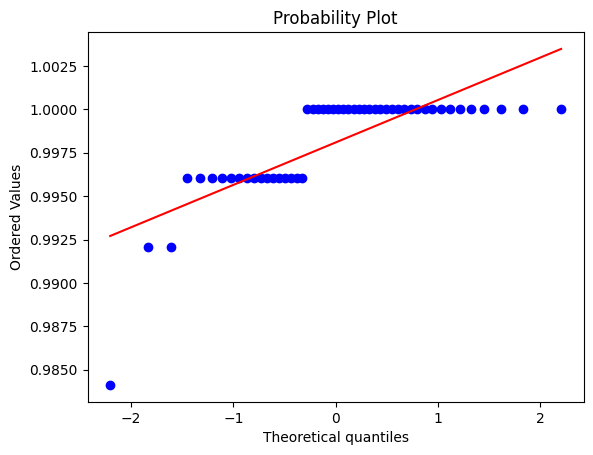

In [ ]:
fig, ax = plt.subplots()
probplot(cumulative_avg_acc[:, 0], plot=ax)

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  5., 24., 19.]),
 array([0.5 , 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 ,
        0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71,
        0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82,
        0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93,
        0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  ]),
 <BarContainer object of 50 artists>)

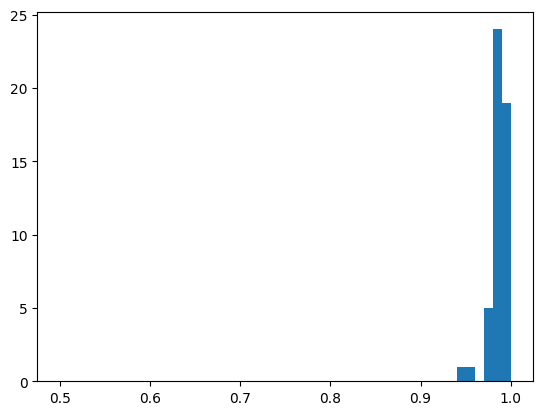

In [ ]:
plt.hist(cumulative_avg_acc[:, 1], bins=50, range=[0.5, 1])